### **Load Data**

In [1]:
import pandas as pd

# Function to load the dataset
def load_data(df):
    return pd.read_csv(file_path)

# Load the dataset
file_path = '../data/flight_df.csv'

# Load the data as a dataframe
df = load_data(file_path)

# Select specified columns for app
selected_columns = ['Inflight wifi service',
                    'Online boarding',
                    'Business Travel',
                    'Inflight entertainment',
                    'Loyal Customer',
                    'Checkin service',
                    'Flight Distance',
                    'Age',
                    'Seat comfort',
                    'Class',
                    'satisfied']

# Filter the dataframe to use only the selected columns
df = df[selected_columns]
df.head()

,Inflight wifi service,Online boarding,Business Travel,Inflight entertainment,Loyal Customer,Checkin service,Flight Distance,Age,Seat comfort,Class,satisfied
0,2,2,1,2,1,3,2062,26,2,3,0
1,5,4,1,4,1,4,680,52,4,3,1
2,3,3,0,3,1,4,188,28,3,1,0
3,3,4,1,3,1,4,453,54,4,3,0
4,4,4,1,4,1,3,775,40,4,1,0


### **Model Validation**

In [2]:
from sklearn.model_selection import train_test_split

# Define target and features
y = df['satisfied']
X = df.drop(columns='satisfied')

In [3]:
import os

file = '..data/app_flight_df.csv'

try:
    # Save the features dataframe for the app
    X.to_csv(file, index=False)
    
    # Confirm save if successful
    if os.path.exists(file):
        print(f'Dataframe saved successfully to: {file}')
    else:
        print(f'Failed to save dataframe: {file}')
    
except Exception as error:
    print(f'Error saving dataframe to {file}: {error}')

Error saving dataframe to ..data/app_flight_df.csv: Cannot save file into a non-existent directory: '..data'


In [4]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for class imbalance
y.value_counts(normalize=True)

satisfied
0    0.56695
1    0.43305
Name: proportion, dtype: float64

### **Preprocessing**

In [5]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

# Create preprocessing pipeline
def create_preprocessing_pipeline():
    
    # Select numeric and categorical columns
    num_cols = make_column_selector(dtype_include = 'number')
    cat_cols = make_column_selector(dtype_include = 'object')
    
    # Instantiate the transformers
    scaler = StandardScaler()
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    knn_imputer = KNNImputer(n_neighbors=2, weights='uniform')
    
    # Create pipeline
    num_pipe = Pipeline([
        ('imputer', knn_imputer),
        ('scaler', scaler),
    ])
    
    cat_pipe = Pipeline([
        ('encoder', ohe)
    ])
    
    preprocessor = ColumnTransformer([
        ('numeric', num_pipe, num_cols),
        ('categorical', cat_pipe, cat_cols),
    ], remainder='drop')
    
    return preprocessor

# Create preprocessor object
preprocessor = create_preprocessing_pipeline()

In [6]:
# conda install conda-forge::imbalanced-learn

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Create sampler pipeline
def make_sampler_pipeline(sampler):
    return ImbPipeline([
        ('sampler', sampler)
    ])
    
# Preprocess and rebalance data
def preprocess_and_rebalance_data(preprocessor, X_train, X_test, y_train):
    
    # Transform training data into the fitted transformer
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    
    # Create sampling pipeline
    sampler = make_sampler_pipeline(SMOTE(random_state=42))
    
    # Balance training data
    X_train_balanced, y_train_balanced = sampler.fit_resample(X_train_transformed, y_train)
    
    return X_train_balanced, X_test_transformed, y_train_balanced

# Preprocess and rebalance the data
X_train_balanced, X_test_transformed, y_train_balanced = preprocess_and_rebalance_data(preprocessor, X_train, X_test, y_train)

# Convert preprocessed data back into a dataframe
X_train_balanced_df = pd.DataFrame(X_train_balanced)
X_test_transformed_df = pd.DataFrame(X_test_transformed)

### **Machine Learning**

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    
    # Create predictions on the training set
    train_preds = np.rint(model.predict(X_train)) # np.rint = Round to the nearest INTeger
    test_preds = np.rint(model.predict(X_test))
    
    # Classification report
    train_report = classification_report(y_train, train_preds)
    test_report = classification_report(y_test, test_preds)
    
    # Confusion matrix
    cm_train = confusion_matrix(y_train, train_preds)
    cm_test = confusion_matrix(y_test, test_preds)
    
    # Format all figures in dark mode
    plt.style.use('dark_background')
    
    # Plot train summary and confusion matrix side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    # First axes
    axes[0].text(0.01, 0.05, str(train_report), {'fontsize': 12}, fontproperties='monospace')
    axes[0].axis('off')
    # Second axes
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp_train.plot(ax=axes[1], cmap='Blues')
    axes[1].set_title('Confusion Matrix - Training Set')
    
    # Plot test summary and confusion matrix side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    # First axes
    axes[0].text(0.01, 0.05, str(test_report), {'fontsize': 12}, fontproperties='monospace')
    axes[0].axis('off')
    # Second axes
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_train.plot(ax=axes[1], cmap='Purples')
    axes[1].set_title('Confusion Matrix - Testing Set')
    
    plt.show()
    
    return train_report, test_report

In [8]:
from sklearn.pipeline import Pipeline

# Create ML pipeline
def train_and_predict_model(X_train, y_train, X_test, preprocessor, model):
    
    # Combine preprocessing pipeline and model
    model_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model),
    ])
    
    # Fit the pipeline on the training data
    model_pipe.fit(X_train, y_train)
    
    # Save predictions
    train_preds = model_pipe.predict(X_train)
    test_preds = model_pipe.predict(X_test)
    
    return train_preds, test_preds

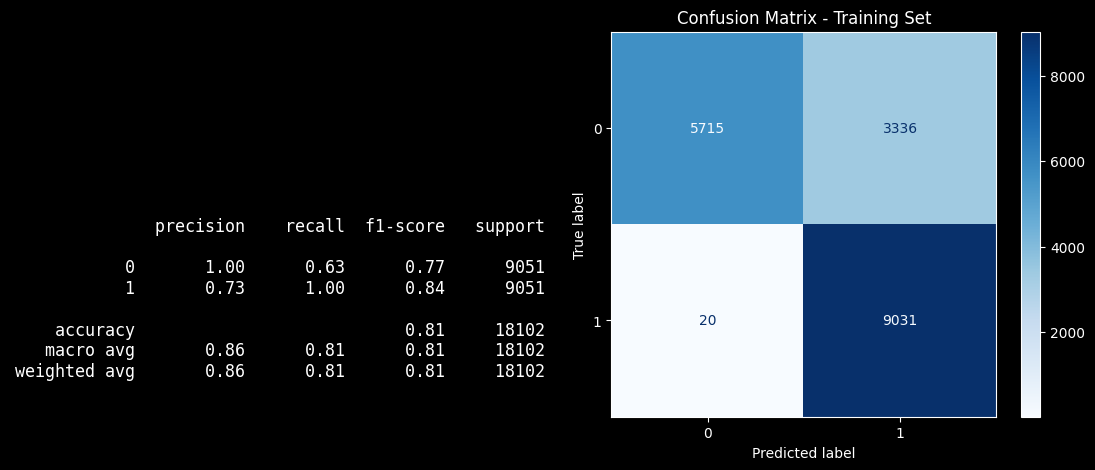

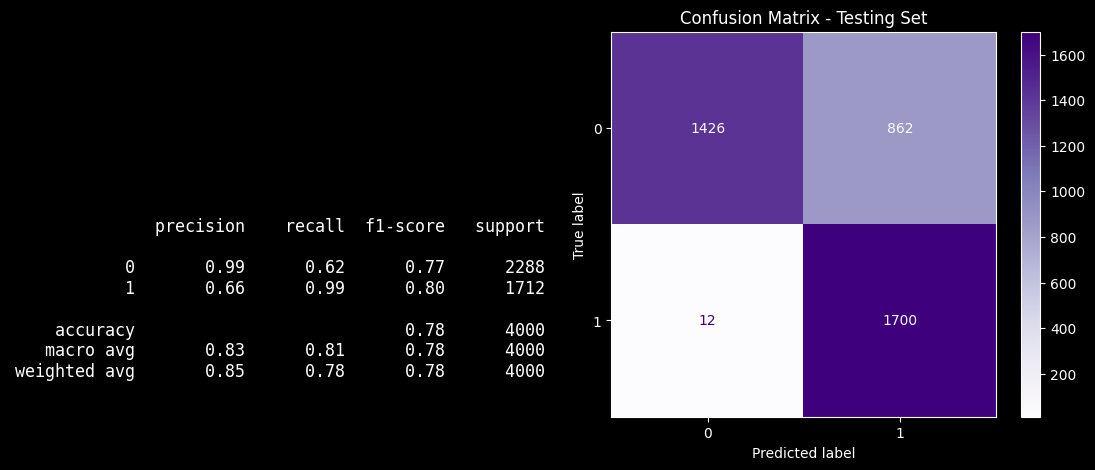

In [9]:
import lightgbm as lgb

# Instantiate the LGBMClassifier
lgb_model = lgb.LGBMClassifier(verbose=-1, random_state=42)

# Create and save predictions
train_preds, test_preds = train_and_predict_model(X_train_balanced_df, y_train_balanced, X_test_transformed_df, preprocessor, lgb_model)

# Return the train and test reports
train_report, test_report = evaluate_model(lgb_model, X_train_balanced_df, y_train_balanced, X_test_transformed_df, y_test)

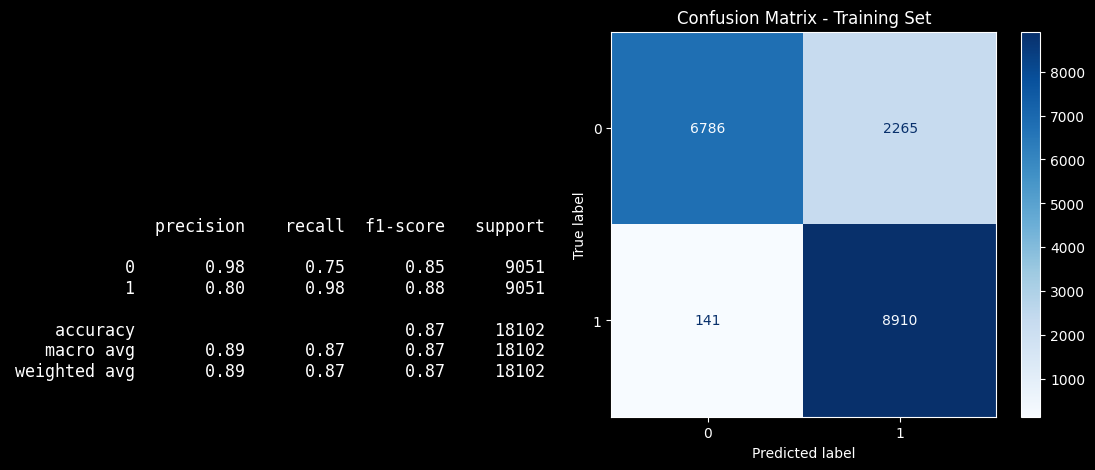

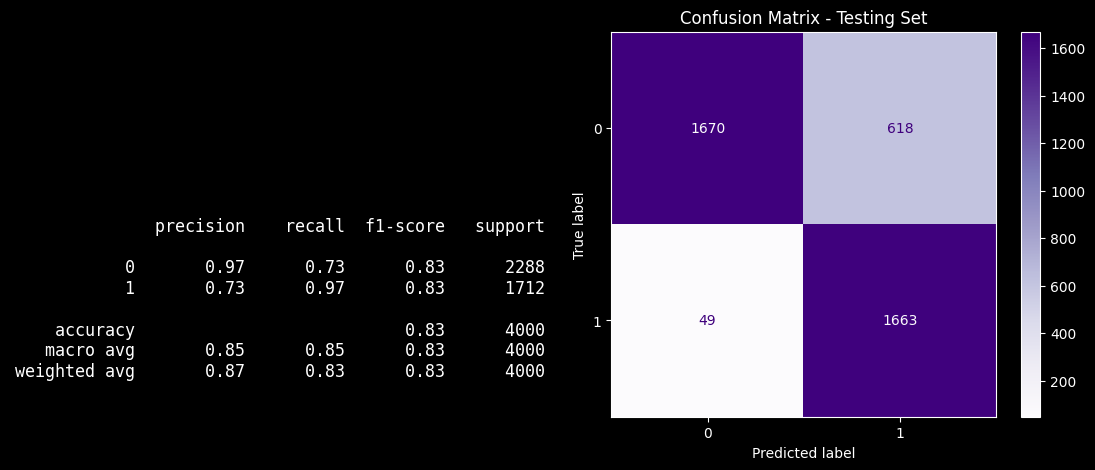

In [10]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate the DecisionTreeClassifier
dec_tree = DecisionTreeClassifier()

# Create and save predictions
train_preds, test_preds = train_and_predict_model(X_train_balanced_df, y_train_balanced, X_test_transformed_df, preprocessor, dec_tree)

# Return the train and test reports
train_report, test_report = evaluate_model(dec_tree, X_train_balanced_df, y_train_balanced, X_test_transformed_df, y_test)

### **Model Evaluation**

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Train model
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    
    return model

# Get feature importance
def get_feature_importance(model):
    
    feature_names = X_train.columns
    importance = model.feature_importances_
        
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False)
    
    return feature_importance

# Plot feature importance
def plot_feature_importance(feature_importance, title):
    
    plt.figure(figsize=(10, 6))
    
    # Barplot
    sns.barplot(
        data=feature_importance,
        x='importance',
        y='feature',
        palette='Spectral_r',
        hue='feature'
    )
    
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# import matplotlib.pyplot as plt
# import seaborn as sns

# # Ensure reproducibility
# np.random.seed(42)

# # Train the model
# def train_model(model, X_train, y_train):
#     model.fit(X_train, y_train)
#     return model

# # Get feature importance
# def get_feature_importance(model, feature_names):
    
#     importance = model.feature_importances_
    
#     feature_importance = pd.DataFrame({
#         'feature': feature_names,
#         'importance': importance
#     }).sort_values(by='importance', ascending=False)
    
#     return feature_importance

# # Plot the features
# def plot_feature_importance(feature_importance, title):
    
#     plt.figure(figsize=(10, 6))
    
#     # Barplot
#     sns.barplot(
#         x='importance',
#         y='feature',
#         data=feature_importance,
#         palette='viridis',
#         hue='feature'
#     )
    
#     plt.title(title)
#     plt.xlabel('Importance')
#     plt.ylabel('Feature')
#     plt.show()

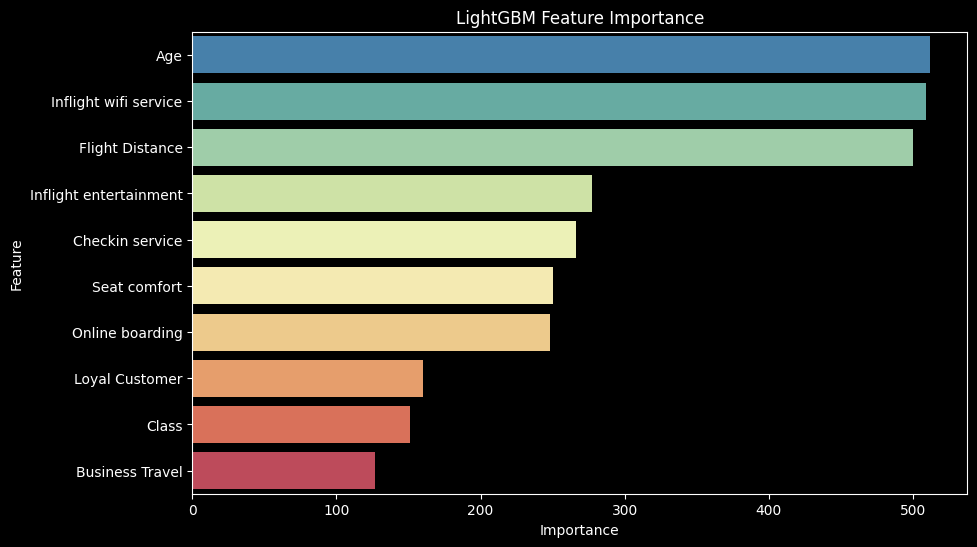

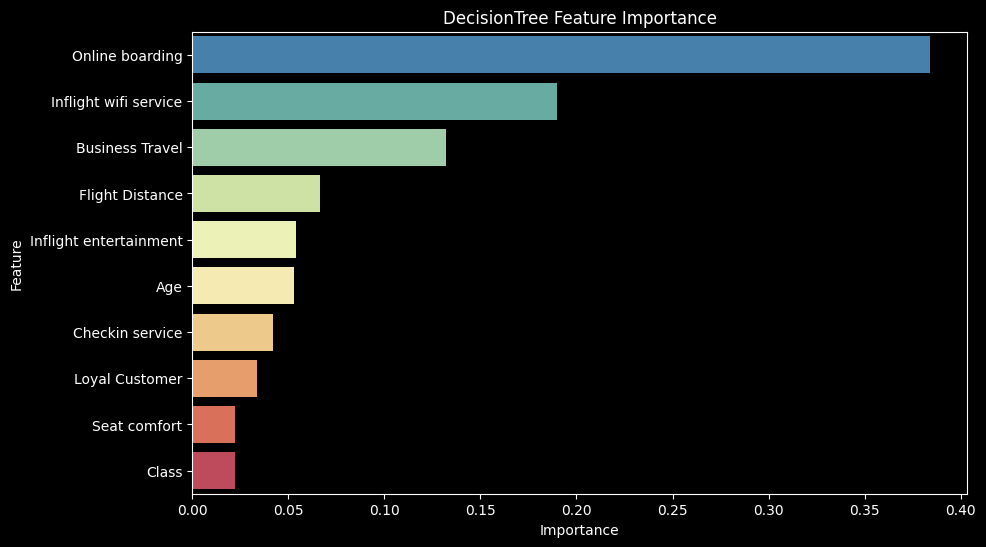

In [12]:
# Train LGBMClassifier
trained_lgb_model = train_model(lgb_model, X_train_balanced, y_train_balanced)

# Get and plot feature importance of LGBMClassifier
lgbm_feature_importance = get_feature_importance(trained_lgb_model)
plot_feature_importance(lgbm_feature_importance, title='LightGBM Feature Importance')

# Train DecisionTreeClassifier
trained_dec_tree = train_model(dec_tree, X_train_balanced, y_train_balanced)

# Get and plot feature importance of DecisionTreeClassifier
dec_tree_feature_importance = get_feature_importance(trained_dec_tree)
plot_feature_importance(dec_tree_feature_importance, title='DecisionTree Feature Importance')

# # Get feature names
# feature_names = X_train.columns

# # Train LGBMClassifier
# trained_lgbm_model = train_model(lgbm_model, X_train_balanced, y_train_balanced)

# # Get and plot feature importances of the LGBMClassifier
# lgbm_feature_importance = get_feature_importance(trained_lgbm_model, feature_names)
# plot_feature_importance(lgbm_feature_importance, title='LightGBM Feature Importance')

# # Train DecisionTreeClassifier
# trained_dec_tree = train_model(dec_tree, X_train_balanced, y_train_balanced)

# # Get and plot feature importances of the DecisionTreeClassifier
# dec_tree_feature_importance = get_feature_importance(trained_dec_tree, feature_names)
# plot_feature_importance(dec_tree_feature_importance, title='DecisionTreeClassifier Feature Importance')

### **Save Models**

In [13]:
import joblib
import os

# Save model
def save_model(model, model_path):
    try:
        # Check if model directory exists
        dir_name = os.path.dirname(model_path)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
            
        # Save the model using joblib
        joblib.dump(model, model_path) 
        
        # Confirm save if successful
        if os.path.exists(model_path):
            print(f'Model saved successfully to: {model_path}')
        else:
            print(f'Failed to save model: {model_path}')
                
    except Exception as error:
        print(f'Error saving mode to {model_path}: {error}')

In [14]:
# Save the LGBMClassifier
model_path = '../models/lgb_model.joblib'
save_model(lgb_model, model_path)

Model saved successfully to: ../models/lgb_model.joblib


In [15]:
# Save the DecisionTreeClassifier
model_path = '../models/dec_tree.joblib'
save_model(dec_tree, model_path)

Model saved successfully to: ../models/dec_tree.joblib
